# Building Footprint Extraction for the USA

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/building_footprints_usa.ipynb)

## Install package
To use the `geoai-py` package, ensure it is installed in your environment. Uncomment the command below if needed.

In [1]:
%pip install geoai-py

## Import libraries

In [2]:
import geoai

## Download sample data

In [3]:
raster_url = (
    "2.tif"
)
vector_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train_buildings.geojson"

In [4]:
raster_path = geoai.download_file(raster_url)

File already exists: 2.tif


In [ ]:
vector_path = geoai.download_file(vector_url)

## Initialize building footprint extraction pretrained model

The pretained model is adapted from the Esri [building footprint extraction](https://www.arcgis.com/home/item.html?id=a6857359a1cd44839781a4f113cd5934) model for the USA. Credits to Esri for the model.

In [5]:
extractor = geoai.BuildingFootprintExtractor()

Model path not specified, downloading from Hugging Face...


building_footprints_usa.pth:   0%|          | 0.00/176M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--giswqs--geoai/snapshots/f9c3c385b3848cff79f130ae823aeeba0fa8457f/building_footprints_usa.pth
Model loaded successfully


## Extract building footprints

### Option 1: Extract building footprints as raster

In [ ]:
mask_path = extractor.save_masks_as_geotiff(
    raster_path=raster_path,
    output_path="building_masks.tif",
    confidence_threshold=0.5,
    mask_threshold=0.5,
)

Convert raster to vector

In [ ]:
gdf = extractor.masks_to_vector(
    mask_path=mask_path,
    output_path="building_masks.geojson",
    simplify_tolerance=1.0,
)

### Option 2: Extract building footprints as vector

In [6]:
output_path = "naip_buildings.geojson"
gdf = extractor.process_raster(
    raster_path,
    output_path="buildings.geojson",
    batch_size=4,
    confidence_threshold=0.5,
    overlap=0.25,
    nms_iou_threshold=0.5,
    min_object_area=100,
    max_object_area=None,
    mask_threshold=0.5,
    simplify_tolerance=1.0,
)

Processing with parameters:
- Confidence threshold: 0.5
- Tile overlap: 0.25
- Chip size: (512, 512)
- NMS IoU threshold: 0.5
- Mask threshold: 0.5
- Min object area: 100
- Max object area: None
- Simplify tolerance: 1.0
- Filter edge objects: True
- Edge buffer size: 20 pixels
Dataset initialized with 8 rows and 16 columns of chips
Image dimensions: 8192 x 4096 pixels
Chip size: 512 x 512 pixels
CRS: EPSG:25831
Processing raster with 32 batches


100%|██████████| 32/32 [00:31<00:00,  1.00it/s]


Objects before filtering: 132
Objects after filtering: 127
Saved 127 objects to buildings.geojson


## Regularize building footprints

In [12]:
gdf_regularized = extractor.regularize_buildings(
    gdf=gdf,
    min_area=100,
    angle_threshold=15,
    orthogonality_threshold=0.3,
    rectangularity_threshold=0.7,
)

Regularizing 127 objects...
- Angle threshold: 15° from 90°
- Min orthogonality: 30.0% of angles
- Min rectangularity: 70.0% of bounding box area


100%|██████████| 127/127 [00:00<00:00, 1656.28it/s]

Regularization completed:
- Total objects: 127
- Rectangular objects: 0 (0.0%)
- Other regularized objects: 0 (0.0%)
- Unmodified objects: 127 (100.0%)


## Visualize building footprints

In [17]:
gdf.head()

,geometry,confidence,class,AREA
70,"POLYGON ((427048.2 4575090.4, 427048.2 4575090...",0.999673,1,5.08
130,"POLYGON ((428620 4574819.6, 428619.8 4574819.4...",0.981381,1,91.86
18,"POLYGON ((427816.8 4575388.8, 427816.6 4575388...",0.981153,1,12.04
9,"POLYGON ((427540 4575342.2, 427540 4575341.6, ...",0.976784,1,18.90
31,"POLYGON ((427970.6 4575299.4, 427970.4 4575299...",0.968451,1,22.88


In [16]:
gdf['AREA']=gdf['geometry'].area

In [8]:
geoai.view_vector_interactive(
    gdf, column="confidence", layer_name="Building", tiles="Satellite"
)

In [9]:
geoai.view_vector_interactive(
    gdf, column="confidence", layer_name="Building", tiles=raster_url
)

In [13]:
geoai.view_vector_interactive(
    gdf_regularized, column="confidence", layer_name="Building", tiles=raster_url
)

Using confidence values (range: 0.50 - 1.00)
Visualization saved to naip_buildings.png
Sample visualization saved to naip_buildings_sample.png


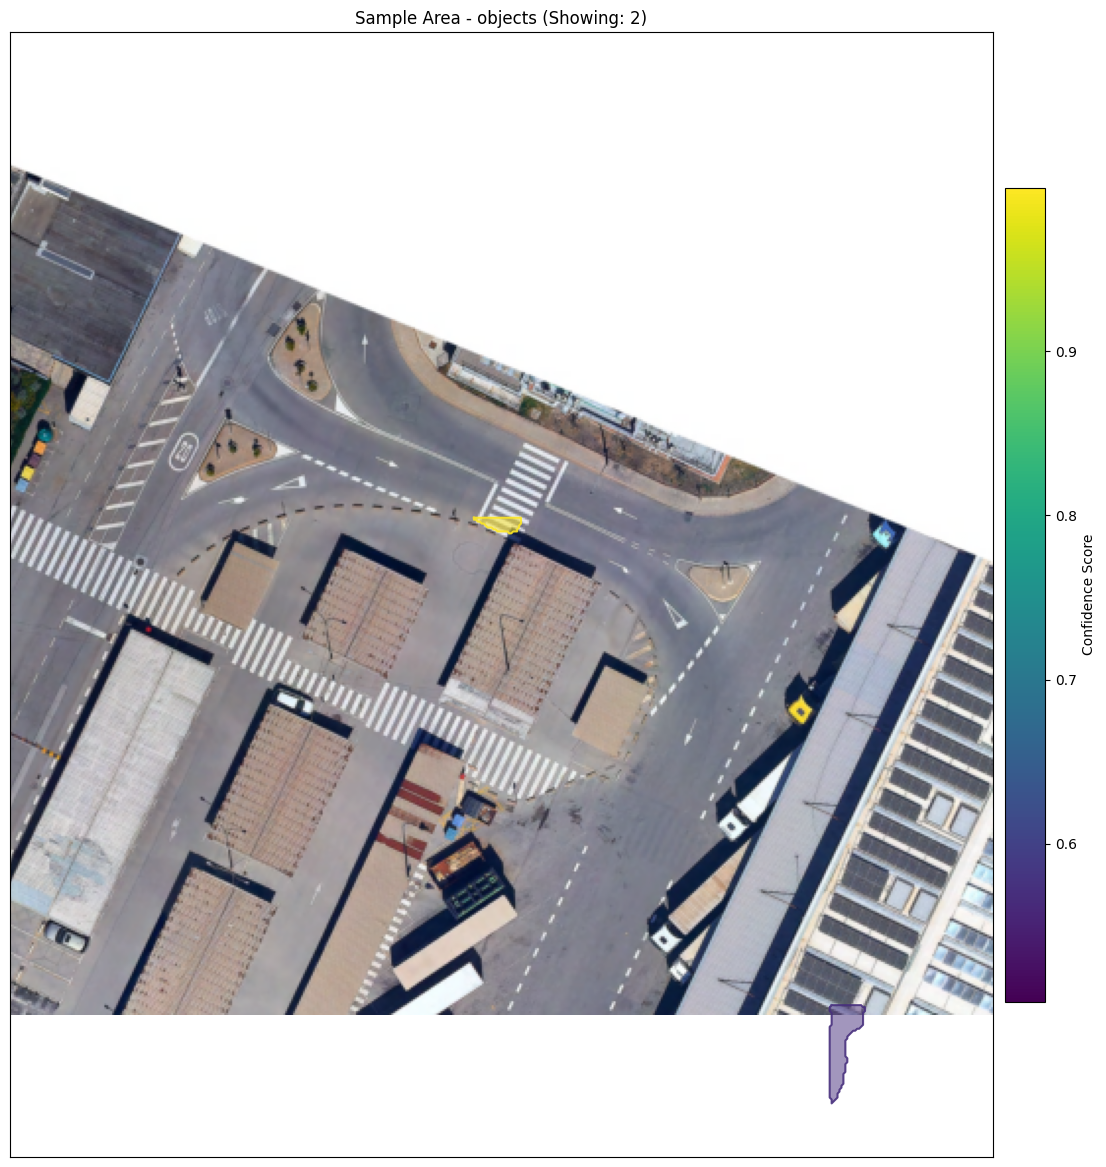

In [14]:
extractor.visualize_results(raster_path, gdf, output_path="naip_buildings.png")

Using confidence values (range: 0.50 - 1.00)
Visualization saved to naip_buildings_regularized.png
Sample visualization saved to naip_buildings_regularized_sample.png


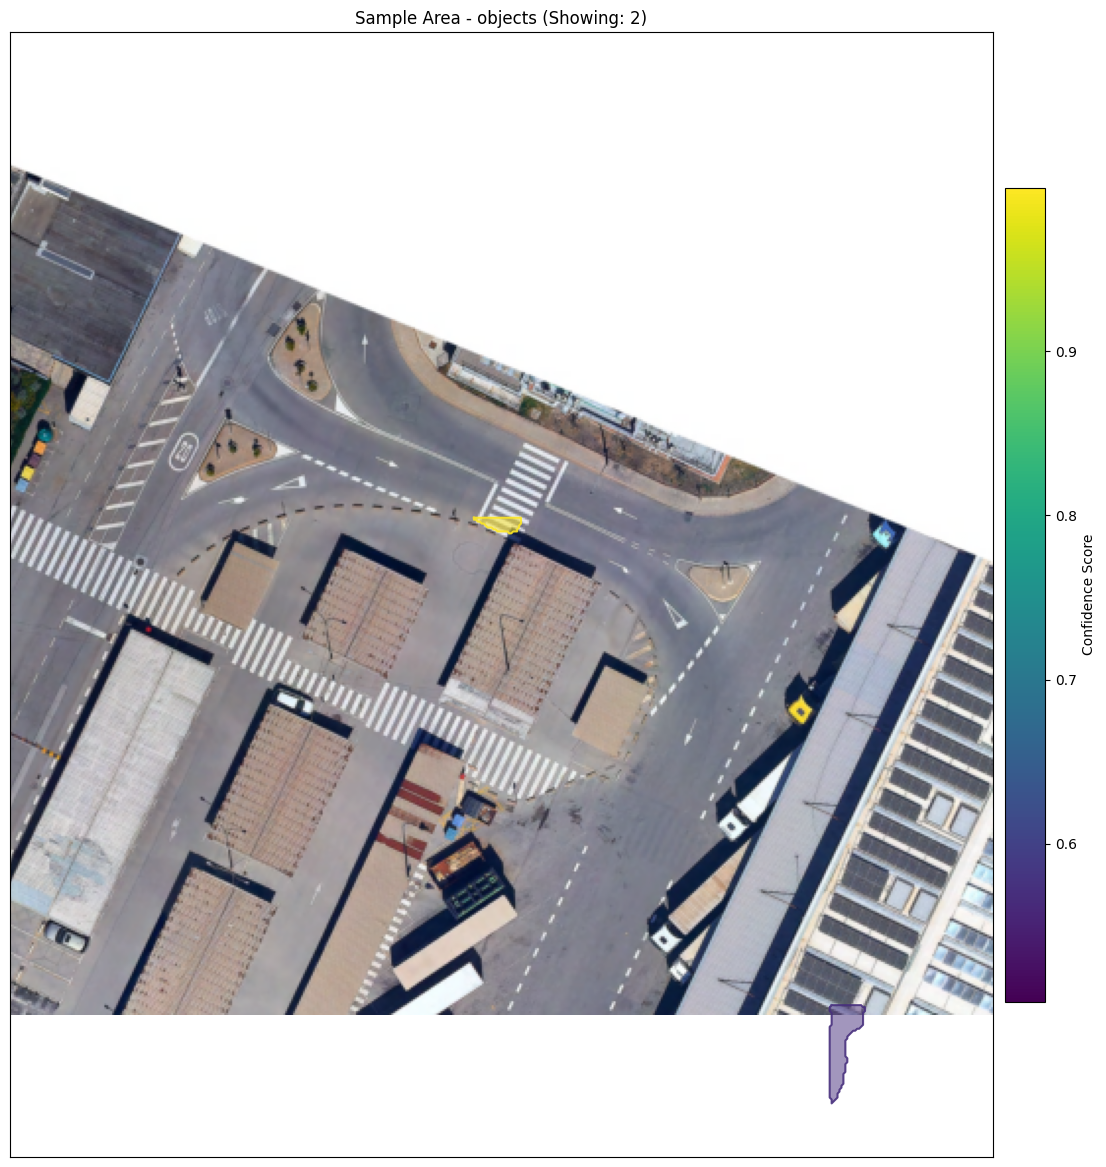

In [15]:
extractor.visualize_results(
    raster_path, gdf_regularized, output_path="naip_buildings_regularized.png"
)